In [1]:
import pandas as pd # data preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import itertools # plotting confusion matrix
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [3]:
df["condition"].value_counts()

Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                                     2321

In [4]:
df_train = df[(df["condition"] == "Birth Control") | (df["condition"] == "Depression") | (df["condition"] == "High Blood Pressure") | (df["condition"] == "Diabetes, Type 2")]

df_train.head(20)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8.0,"December 8, 2016",1
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10.0,"March 9, 2017",54
14,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3.0,"August 7, 2014",10
22,227020,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9.0,"August 11, 2014",11
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8.0,"May 7, 2011",3
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4.0,"April 27, 2016",3
50,156544,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10.0,"October 24, 2017",24
59,106703,Implanon,Birth Control,"""Never again! After being on depo I was suppos...",2.0,"August 20, 2015",1


In [5]:
df.shape

(161297, 7)

In [6]:
df_train.shape

(42732, 7)

In [7]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

In [8]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[0]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

# EDA

In [9]:
X["condition"].value_counts()

Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: condition, dtype: int64

In [10]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
9,Birth Control,"""I had been on the pill for many years. When m..."
11,Depression,"""I have taken anti-depressants for years, with..."
14,Birth Control,"""Started Nexplanon 2 months ago because I have..."


In [11]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

Text(0.5, 1.0, 'Word cloud for Birth control')

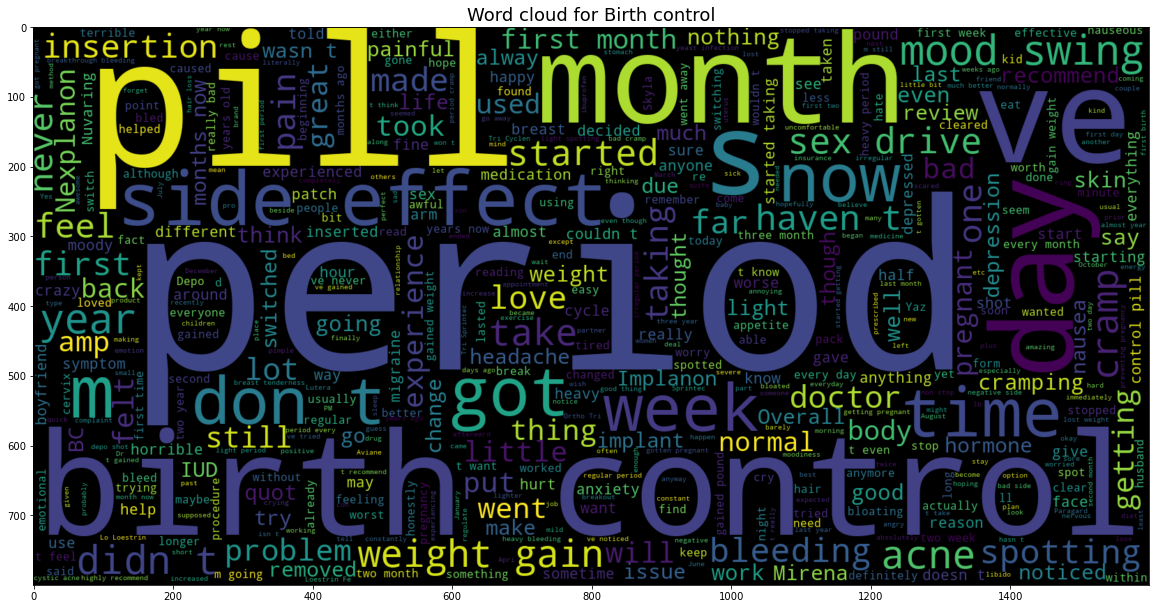

In [12]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_birth.review))

plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=18)

Text(0.5, 1.0, 'Word cloud for Depression')

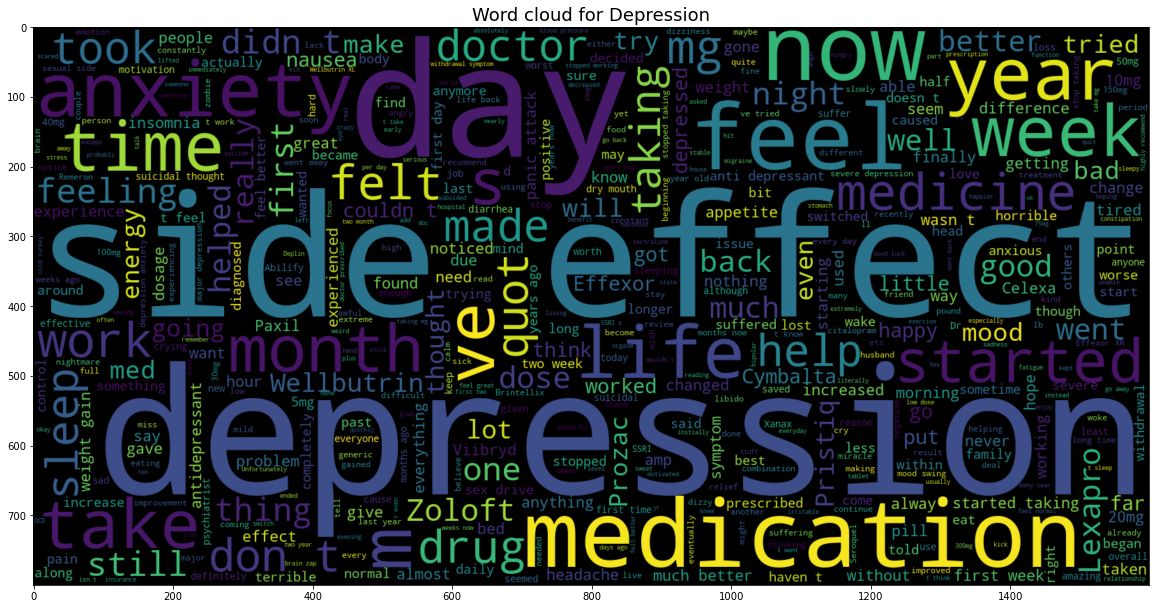

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=18)

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

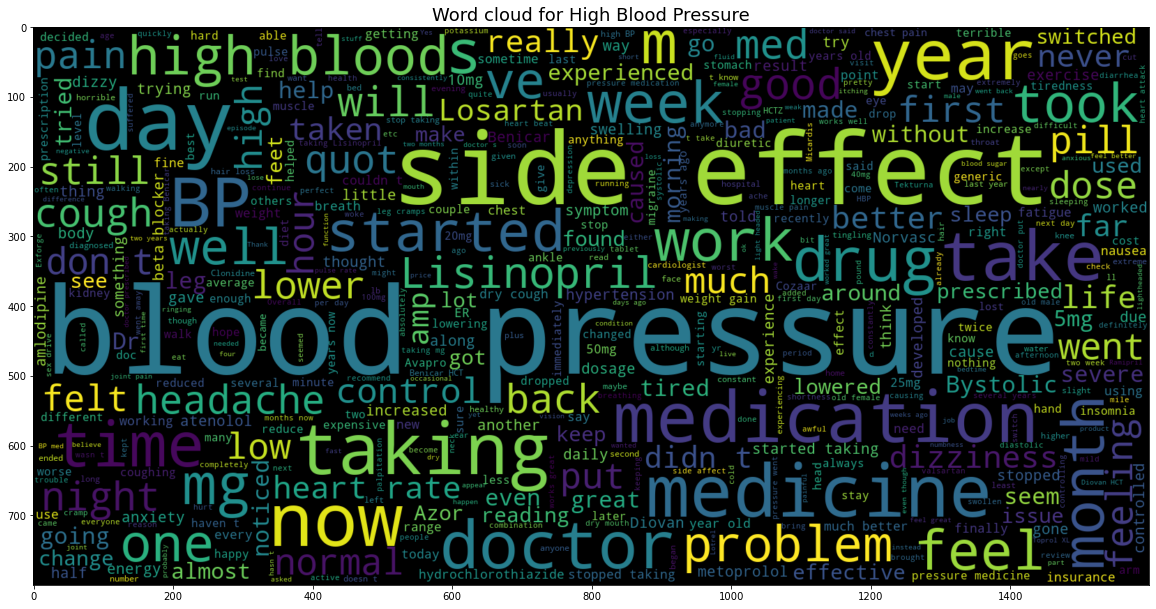

In [14]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=18)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

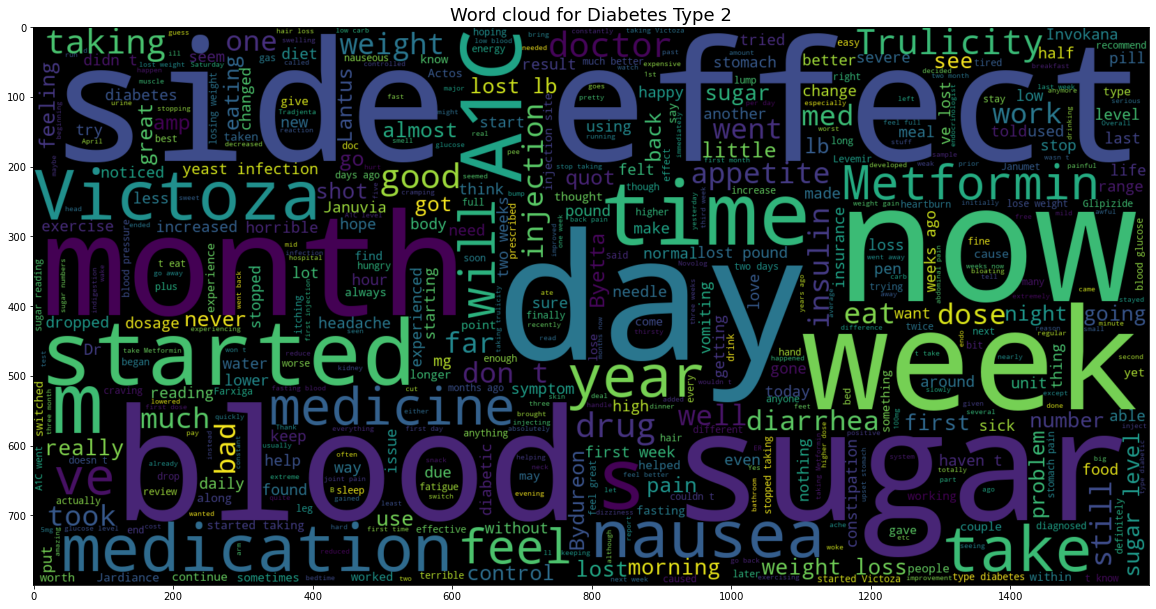

In [15]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=18)

In [16]:
X["review"][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [17]:
X["review"][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [18]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [19]:
# Sets width of column to maximum
pd.set_option("max_colwidth", -1)

<ipython-input-19-809cffd4b23c>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("max_colwidth", -1)


In [20]:
X.head()

,condition,review
2,Birth Control,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."
3,Birth Control,"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"
9,Birth Control,"I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger."
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."
14,Birth Control,"Started Nexplanon 2 months ago because I have a minimal amount of contraception&#039;s I can take due to my inability to take the hormone that is used in most birth controls. I&#039;m trying to give it time because it is one of my only options right now. But honestly if I had options I&#039;d get it removed.\r\nI&#039;ve never had acne problems in my life, and immediately broke out after getting it implanted. Sex drive is completely gone, and I used to have sex with my boyfriend a few days a week, now its completely forced and not even fun for me anymore. I mean I&#039;m on birth control because I like having sex but don&#039;t want to get pregnant, why take a birth control that takes away sex? Very unhappy and hope that I get it back with time or I&#039;m getting it removed."


# Removing Stopwords

In [21]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# Lemmatization

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [23]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [24]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

sportingly
very
troubled


In [25]:
from bs4 import BeautifulSoup
import re

In [26]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmatization
    lemmatize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmatize_words))

In [27]:
X['review_clean'] = X['review'].apply(review_to_words)

X.head()

,condition,review,review_clean
2,Birth Control,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.",used take another oral contraceptive pill cycle happy light period max day side effect contained hormone gestodene available u switched lybrel ingredient similar pill ended started lybrel immediately first day period instruction said period lasted two week taking second pack two week third pack thing got even worse third period lasted two week end third week still daily brown discharge positive side side effect idea period free tempting ala
3,Birth Control,"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch",first time using form birth control glad went patch month first decreased libido subsided downside made period longer day exact used period day max also made cramp intense first two day period never cramp using birth control happy patch
9,Birth Control,"I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger.",pill many year doctor changed rx chateal effective really help completely clearing acne take month though gain extra weight develop emotional health issue stopped taking bc started using natural method birth control started take bc hate acne came back age really hope symptom like depression weight gain begin affect older also naturally moody may worsen thing negative mental rut today also hope push edge believe depressed hopefully like younger
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.",taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking month feel like normal person first time ever best thing side effect
14,Birth Control,"Started Nexplanon 2 months ago because I have a minim

In [28]:
X_feat=X['review_clean']
y=X['condition']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Bag of Words

In [31]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

# Machine Learning Model: Naive Bayes

accuracy:   0.970
Confusion matrix, without normalization


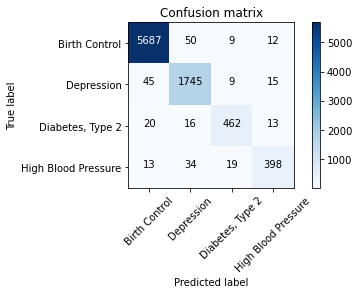

In [32]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred_NB = mnb.predict(count_test)
score_NB = metrics.accuracy_score(y_test, pred_NB)
print("accuracy:   %0.3f" % score_NB)

cm = metrics.confusion_matrix(y_test, pred_NB, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.978
Confusion matrix, without normalization


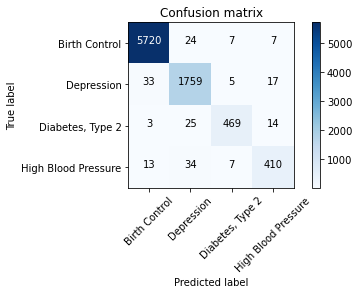

In [33]:
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

passive_CL = PassiveAggressiveClassifier()
passive_CL.fit(count_train, y_train)
pred_CL = passive_CL.predict(count_test)
score_CL = metrics.accuracy_score(y_test, pred_CL)
print("accuracy:   %0.3f" % score_CL)
cm = metrics.confusion_matrix(y_test, pred_CL, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

# TFIDF

accuracy:   0.921
Confusion matrix, without normalization


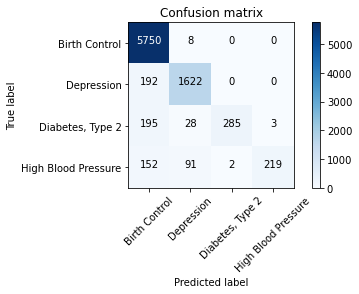

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_NB = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_NB = tfidf_vectorizer_NB.fit_transform(X_train)
tfidf_test_NB = tfidf_vectorizer_NB.transform(X_test)

mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_NB, y_train)
pred = mnb_tf.predict(tfidf_test_NB)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

# Log Loss for MultinomialNB

In [35]:
from sklearn.metrics import log_loss

# Make predictions on the test set
pred_prob = mnb_tf.predict_proba(tfidf_test_NB)

# Calculate the log loss
logloss = log_loss(y_test, pred_prob)

print("Log loss: %0.3f" % logloss)

Log loss: 0.209


# Machine Learning Model TFIDF

accuracy:   0.986
Confusion matrix, without normalization


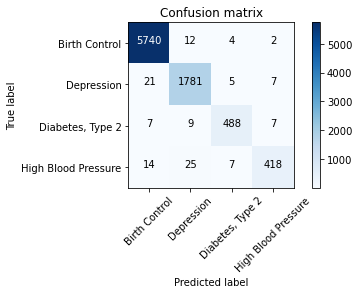

In [36]:
tfidf_vectorizer_CL = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english', max_df = 0.8)

tfidf_train_PCL = tfidf_vectorizer_CL.fit_transform(X_train)
tfidf_test_PCL = tfidf_vectorizer_CL.transform(X_test)

pass_tf_PCL = PassiveAggressiveClassifier()
pass_tf_PCL.fit(tfidf_train_PCL, y_train)

pred = pass_tf_PCL.predict(tfidf_test_PCL)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

# Log Loss for PassiveAggressiveClassifier

In [37]:
# Approximate probabilities using decision function
decision_scores = pass_tf_PCL.decision_function(tfidf_test_PCL)
probabilities = np.exp(decision_scores) / np.sum(np.exp(decision_scores), axis=1, keepdims=True)

# Calculate the log loss
logloss = log_loss(y_test, probabilities)

print("Log loss: %0.3f" % logloss)

Log loss: 0.119


# TFIDF: Bigrams

accuracy: 0.986
Confusion matrix, without normalization


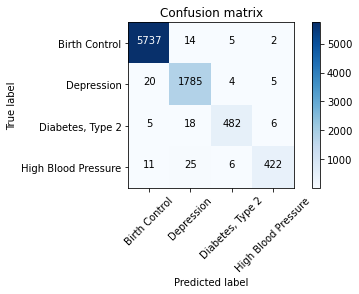

In [38]:
tfidf_vectorizer_bigram = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_bigram = tfidf_vectorizer_bigram.fit_transform(X_train)
tfidf_test_bigram = tfidf_vectorizer_bigram.transform(X_test)

pass_tf_bigram_PCL = PassiveAggressiveClassifier()
pass_tf_bigram_PCL.fit(tfidf_train_bigram, y_train)
pred = pass_tf_bigram_PCL.predict(tfidf_test_bigram)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

# TFIDF: Trigrams

accuracy: 0.985
Confusion matrix, without normalization


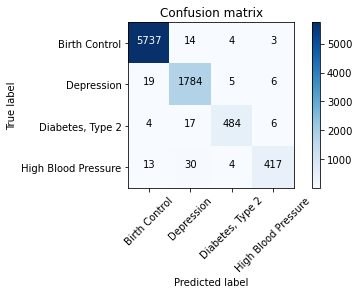

In [39]:
tfidf_vectorizer_trigram = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_trigram = tfidf_vectorizer_trigram.fit_transform(X_train)
tfidf_test_trigram = tfidf_vectorizer_trigram.transform(X_test)

pass_tf_trigram_PCL = PassiveAggressiveClassifier()
pass_tf_trigram_PCL.fit(tfidf_train_trigram, y_train)
pred = pass_tf_trigram_PCL.predict(tfidf_test_trigram)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

In [40]:
def most_informative_feature_for_class(vectorizer, classifier, class_label, n=10):
    label_id = list(classifier.classes_).index(class_label)
    feature_names = vectorizer.get_feature_names()
    top_n = sorted(zip(classifier.coef_[label_id], feature_names))[-n:]

    for coef, feat in top_n:
        print (class_label, feat, coef)



most_informative_feature_for_class(tfidf_vectorizer_bigram, pass_tf_bigram_PCL, 'Birth Control')

Birth Control cramp 4.361280147705702
Birth Control patch 4.461842856864954
Birth Control spotting 4.695810684045265
Birth Control pregnant 5.257832010326493
Birth Control bleeding 5.35327596123206
Birth Control birth control 5.850639600194683
Birth Control birth 6.166747930223102
Birth Control acne 6.443468079393169
Birth Control pill 7.1494793970764166
Birth Control period 10.020899675419889


In [41]:
most_informative_feature_for_class(tfidf_vectorizer_bigram, pass_tf_bigram_PCL, 'Depression')

Depression viibryd 4.6870168852772975
Depression prozac 4.983630405238685
Depression cymbalta 5.142063756700913
Depression antidepressant 5.226836467685207
Depression effexor 5.694161746489003
Depression lexapro 5.8784776012256685
Depression wellbutrin 6.058847991289551
Depression zoloft 6.344344063730854
Depression pristiq 6.917845487637207
Depression depression 6.96154701824703


In [42]:
most_informative_feature_for_class(tfidf_vectorizer_bigram, pass_tf_bigram_PCL, 'High Blood Pressure')

High Blood Pressure diovan 3.221420341405227
High Blood Pressure metoprolol 3.435194678946704
High Blood Pressure bystolic 3.5257517508492815
High Blood Pressure benicar 3.8667228112315444
High Blood Pressure losartan 3.9177176956374034
High Blood Pressure amlodipine 4.118364767373219
High Blood Pressure cough 4.767328635646738
High Blood Pressure pressure 5.299484499907473
High Blood Pressure lisinopril 5.686088115141171
High Blood Pressure bp 7.4608597726381305


In [43]:
most_informative_feature_for_class(tfidf_vectorizer_bigram, pass_tf_bigram_PCL, 'Diabetes, Type 2')

Diabetes, Type 2 bydureon 3.9290518133610783
Diabetes, Type 2 januvia 4.252141417682069
Diabetes, Type 2 byetta 4.326602144927077
Diabetes, Type 2 insulin 4.429469134001096
Diabetes, Type 2 injection 4.70497625589172
Diabetes, Type 2 invokana 5.223701015438682
Diabetes, Type 2 trulicity 5.521936365624894
Diabetes, Type 2 victoza 6.853695953829736
Diabetes, Type 2 sugar 7.18203648039856
Diabetes, Type 2 metformin 7.240064180219761


In [44]:
X.tail()

,condition,review,review_clean
161273,Birth Control,"I have had the Nexplanon since Dec. 27, 2016 \r\r\nI got my first period at the end of January and it lasted about a month and a half. In March of 2017 I didn&#039;t bleed for close to three weeks and then started bleeding again March 28th and have been bleeding every since. I have gained about 13 lbs so far since getting the birth control. Although for now the weight gain isn&#039;t a deal breaker for me but the bleeding is.. I am trying to be very patient to see how my body adjusts to the implant. It has been three months so far and I have my fingers crossed that my cycle will go away for awhile.",nexplanon since dec got first period end january lasted month half march bleed close three week started bleeding march th bleeding every since gained lb far since getting birth control although weight gain deal breaker bleeding trying patient see body adjusts implant three month far finger crossed cycle go away awhile
161278,"Diabetes, Type 2",I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me,got diagnosed type doctor prescribed invokana metformin beginning sugar went normal second week losing much weight side effect yet miracle medicine
161286,Depression,"This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",third med tried anxiety mild depression week hate much dizzy major diarrhea feel worse started contacting doc changing asap
161290,High Blood Pressure,"I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",tekturna day effect immediate also calcium channel blocker tiazac hydrochlorothiazide put tekturna palpitation experienced diovan ugly drug opinion company produce however palpitation pretty bad diovan hour monitor ekg etc day substituting tekturna diovan palpitation
161291,Birth Control,"This would be my second month on Junel. I&#039;ve been on Birth Control for about 10 years now. I changed due to spotting and increased mood swings with my previous birth control. Since the switch I have had shorter periods about 2-3 days, but I have gained major weight and increased appetite. I switched up my regular exercise routine and still have not managed to drop the extra 7 lbs ;(",would second month junel birth control year changed due spotting increased mood swing previous birth control since switch shorter period day gained major weight increased appetite switched regular exercise routine still managed drop extra lb


In [45]:
text =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = tfidf_vectorizer_CL.transform(text)
pred1=pass_tf_PCL.predict(test)[0]
pred1

'High Blood Pressure'

In [46]:
text =["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test = tfidf_vectorizer_CL.transform(text)
pred1=pass_tf_PCL.predict(test)[0]
pred1

'Depression'

In [47]:
text =["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
test = tfidf_vectorizer_CL.transform(text)
pred1=pass_tf_PCL.predict(test)[0]
pred1

'Diabetes, Type 2'

In [48]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",8.0,"November 3, 2015",10
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger.""",8.0,"December 8, 2016",1
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.""",10.0,"March 9, 2017",54
14,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have a minimal amount of contraception&#039;s I can take due to my inability to take the hormone that is used in most birth controls. I&#039;m trying to give it time because it is one of my only options right now. But honestly if I had options I&#039;d get it removed.\r\nI&#039;ve never had acne problems in my life, and immediately broke out after getting it implanted. Sex drive is completely gone, and I used to have sex with my boyfriend a few days a week, now its completely forced and not even fun for me anymore. I mean I&#039;m on birth control because I like having sex but don&#039;t want to get pregnant, why take a birth control that takes away sex? Very unhappy and hope that I get it back with time or I&#039;m getting it removed.""",3.0,"August 7, 2014",10


In [49]:
# Extracting Top Drugs

def top_drugs_extractor(condition):
    df_top = df[(df["rating"] >= 9) & (df["usefulCount"] >= 100)].sort_values(by = ["rating", "usefulCount"], ascending = [False, True])
    drug_lst = df_top[df_top["condition"] == condition]["drugName"].head(3).tolist()
    return drug_lst
top_drugs_extractor('Birth Control')

['Ethinyl estradiol / levonorgestrel',
 'Orsythia',
 'Ethinyl estradiol / norethindrone']

In [50]:
def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns=["test_sent"])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer_bigram.transform(df_test["test_sent"])
    prediction = pass_tf_bigram_PCL.predict(tfidf_bigram)
    df_test["prediction"] = prediction
    return df_test

In [51]:
sentences = ["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",
            " This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",
            "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"
            "I am constantly sick. I get morning sickness and I constantly throw up certain foods. Please help me"]

In [52]:
tfidf_trigram = tfidf_vectorizer_trigram.transform(sentences)

predictions = pass_tf_trigram_PCL.predict(tfidf_trigram)

conditions = {
    "High Blood Pressure": "High Blood Pressure",
    "Depression": "Depression",
    "Diabetes, Type 2": "Diabetes, Type 2",
}

for text, label in zip(sentences, predictions):
    target = conditions.get(label, "Birth Control")
    top_drugs = top_drugs_extractor(label)
    
    print("text: ", text, "\nCondition: ", target)
    print("Top 3 Suggested Drugs: ")
    print(top_drugs[0])
    print(top_drugs[1])
    print(top_drugs[2])
    print()


text:  I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations. 
Condition:  High Blood Pressure
Top 3 Suggested Drugs: 
Losartan
Benicar
Olmesartan

text:   This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap. 
Condition:  Depression
Top 3 Suggested Drugs: 
Pristiq
Prozac
Desvenlafaxine

text:  I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I a

In [53]:
df_testsent = predict_text(sentences)
df_testsent

,test_sent,prediction
0,tekturna day effect immediate also calcium channel blocker tiazac hydrochlorothiazide put tekturna palpitation experienced diovan ugly drug opinion company produce however palpitation pretty bad diovan hour monitor ekg etc day substituting tekturna diovan palpitation,High Blood Pressure
1,third med tried anxiety mild depression week hate much dizzy major diarrhea feel worse started contacting doc changing asap,Depression
2,got diagnosed type doctor prescribed invokana metformin beginning sugar went normal second week losing much weight side effect yet miracle medicine mei constantly sick get morning sickness constantly throw certain food please help,"Diabetes, Type 2"


In [54]:
import joblib
joblib.dump(tfidf_vectorizer_trigram, "tfidf_vectorizer_trigram.pkl")
joblib.dump(pass_tf_trigram_PCL, "pass_tf_trigram_PCL.pkl")

['pass_tf_trigram_PCL.pkl']

In [55]:
vectorizer_trigram = joblib.load("tfidf_vectorizer_trigram.pkl")
model = joblib.load("pass_tf_trigram_PCL.pkl")

test = model.predict(vectorizer_trigram.transform(sentences))
test[0]

'High Blood Pressure'